In [1]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import joblib

df = pd.read_csv("/content/salaries.csv")





In [4]:
df

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2025,SE,FT,Software Engineer,218900,USD,218900,US,100,US,M
1,2025,SE,FT,Software Engineer,186065,USD,186065,US,100,US,M
2,2025,SE,FT,System Engineer,158000,USD,158000,US,0,US,M
3,2025,SE,FT,System Engineer,140000,USD,140000,US,0,US,M
4,2025,SE,FT,Data Engineer,164600,USD,164600,US,0,US,M
...,...,...,...,...,...,...,...,...,...,...,...
148516,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L
148517,2021,MI,FT,Principal Data Scientist,151000,USD,151000,US,100,US,L
148518,2020,EN,FT,Data Scientist,105000,USD,105000,US,100,US,S
148519,2020,EN,CT,Business Data Analyst,100000,USD,100000,US,100,US,L


In [3]:
df.shape

(148521, 11)

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148521 entries, 0 to 148520
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   work_year           148521 non-null  int64 
 1   experience_level    148521 non-null  object
 2   employment_type     148521 non-null  object
 3   job_title           148521 non-null  object
 4   salary              148521 non-null  int64 
 5   salary_currency     148521 non-null  object
 6   salary_in_usd       148521 non-null  int64 
 7   employee_residence  148521 non-null  object
 8   remote_ratio        148521 non-null  int64 
 9   company_location    148521 non-null  object
 10  company_size        148521 non-null  object
dtypes: int64(4), object(7)
memory usage: 12.5+ MB
None


In [6]:
print(df.work_year.value_counts())

work_year
2025    75802
2024    62241
2023     8524
2022     1661
2021      218
2020       75
Name: count, dtype: int64


In [7]:
print(df.experience_level.value_counts())

experience_level
SE    85846
MI    45218
EN    13548
EX     3909
Name: count, dtype: int64


In [8]:
print(df.employment_type.value_counts())

employment_type
FT    147623
CT       465
PT       417
FL        16
Name: count, dtype: int64


In [9]:
print(df.job_title.value_counts())

job_title
Data Scientist                      18503
Software Engineer                   16666
Data Engineer                       16136
Data Analyst                        13589
Engineer                            10750
                                    ...  
Lead AI Engineer                        1
AI Software Development Engineer        1
CRM Data Analyst                        1
Staff Machine Learning Engineer         1
Cloud Data Architect                    1
Name: count, Length: 419, dtype: int64


In [10]:
print(df.employee_residence.value_counts())

employee_residence
US    132900
CA      6059
GB      4110
AU       567
NL       470
       ...  
KW         1
AS         1
CN         1
IQ         1
JE         1
Name: count, Length: 104, dtype: int64


In [11]:
print(df.company_location.value_counts())

company_location
US    132963
CA      6060
GB      4119
AU       572
NL       470
       ...  
IR         1
BS         1
IQ         1
CN         1
MD         1
Name: count, Length: 97, dtype: int64


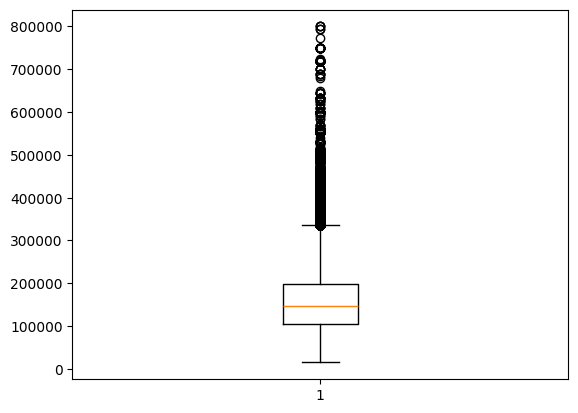

In [15]:
import matplotlib
import matplotlib.pyplot as plt
plt.boxplot(df.salary_in_usd)
plt.show()

In [16]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def preprocess_data(df):
    df = df.dropna(subset=["salary_in_usd"])

    for col in df.select_dtypes(include="object").columns:
        df[col] = df[col].fillna(df[col].mode()[0])
    for col in df.select_dtypes(include=["float64", "int64"]).columns:
        df[col] = df[col].fillna(df[col].median())

    for col in ["job_title", "employee_residence", "company_location"]:
        if col in df.columns:
            top = df[col].value_counts().nlargest(15).index
            df[col] = df[col].where(df[col].isin(top), other="Other")

    cat_cols = df.select_dtypes(include="object").columns
    for col in cat_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

    return df


In [21]:
X = df.drop(columns=["salary_in_usd"])
y = df["salary_in_usd"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = lgb.LGBMRegressor()
model.fit(X_train, y_train)

joblib.dump(model, "model.pkl")
X_test.to_csv("X_test.csv", index=False)
y_test.to_csv("y_test.csv", index=False)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 345
[LightGBM] [Info] Number of data points in the train set: 118816, number of used features: 10
[LightGBM] [Info] Start training from score 157347.042553


In [22]:
import pandas as pd
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

model = joblib.load("model.pkl")
X_test = pd.read_csv("X_test.csv")
y_test = pd.read_csv("y_test.csv")

y_pred = model.predict(X_test)

print(f"MAE : {mean_absolute_error(y_test, y_pred):,.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):,.2f}")
print(f"R²  : {r2_score(y_test, y_pred):.4f}")


MAE : 654.41
RMSE: 4,497.46
R²  : 0.9964


MAE : 654.41
RMSE: 4,497.46
R²  : 0.9964


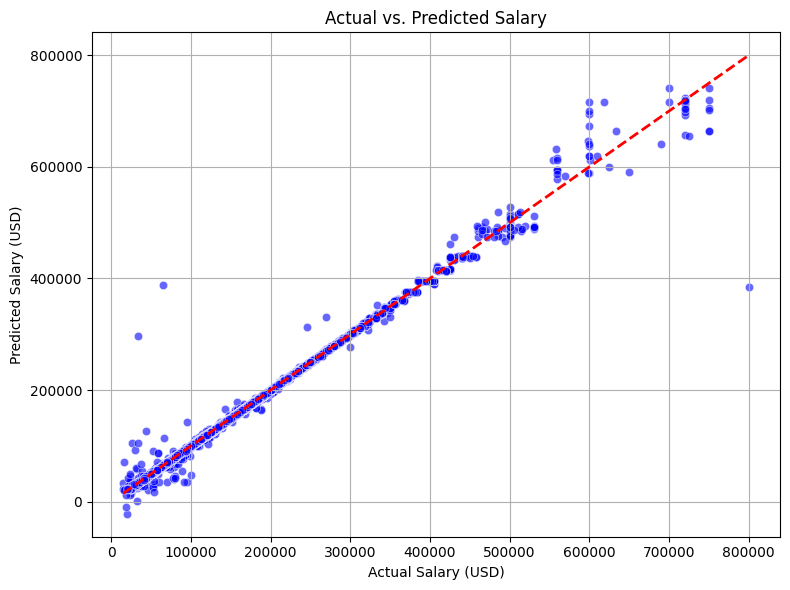

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

model = joblib.load("model.pkl")
X_test = pd.read_csv("X_test.csv")
y_test = pd.read_csv("y_test.csv")

y_pred = model.predict(X_test)

print(f"MAE : {mean_absolute_error(y_test, y_pred):,.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):,.2f}")
print(f"R²  : {r2_score(y_test, y_pred):.4f}")

# --- Actual vs Predicted Plot ---
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test.iloc[:, 0], y=y_pred, alpha=0.6, color='blue', edgecolor='w')
plt.plot([y_test.min().iloc[0], y_test.max().iloc[0]], [y_test.min().iloc[0], y_test.max().iloc[0]], 'r--', lw=2)
plt.xlabel("Actual Salary (USD)")
plt.ylabel("Predicted Salary (USD)")
plt.title("Actual vs. Predicted Salary")
plt.grid(True)
plt.tight_layout()
plt.show()

In [29]:
plt.savefig("actual_vs_predicted.png", dpi=300)


<Figure size 640x480 with 0 Axes>